In [1]:
##imports and setup
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img, NumpyArrayIterator
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model
import cv2 as cv
import keras
#from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions


#mount drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Setting up gpu..
MIXED_PRECISION = True
XLA_ACCELERATE = False  # Didn't work; Dunno Why!

GPUS = tf.config.experimental.list_physical_devices('GPU')


if GPUS:
  try:
    for GPU in GPUS:
      tf.config.experimental.set_memory_growth(GPU, True)
      logical_gpus = tf.config.experimental.list_logical_devices('GPU')
      print(len(GPUS), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as  RE:
    print(RE)

if MIXED_PRECISION:
  policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
  tf.keras.mixed_precision.experimental.set_policy(policy)
  print('Mixed precision enabled')

if XLA_ACCELERATE:
  tf.config.optimizer.set_jit(True)
  print('Accelerated Linear Algebra enabled')

print("Tensorflow version " + tf.__version__)

print('completed')

1 Physical GPUs, 1 Logical GPUs
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale
Mixed precision enabled
Tensorflow version 2.4.1
completed


In [2]:
# Change data_src variable as per your drive
data_src = '/content/drive/MyDrive/Colab/aff_wild'
size = 34947
#Loading the data into the correct format:
train_faces = np.load(data_src+'/train_faces_gray_int.npy')
#normalizing
train_cont = (np.load(data_src+'/train_annotation_2.npy')+1)/2
#delimit = int(len(train_faces)*0.7)
#train_faces = np.asarray(train_faces[:delimit,],dtype=float)
#train_cont = np.asarray(train_cont[:delimit,],dtype=float)
#train_faces=np.reshape(train_faces,(train_faces.shape[0],train_faces.shape[1],train_faces.shape[2],1))
print(train_cont)
print(train_faces)
print('completed')

[[0.56875    0.5055    ]
 [0.608      0.5725    ]
 [0.66925    0.55550003]
 ...
 [0.3765     0.7515    ]
 [0.4125     0.649     ]
 [0.5        0.724     ]]
[[[202 174 117 ... 235 233 235]
  [206 183 127 ... 233 234 234]
  [218 203 152 ... 229 233 234]
  ...
  [  8   6   5 ...  10   6  14]
  [  8   6   5 ...  10   8  15]
  [  8   6   5 ...   8   9  16]]

 [[152 162 153 ... 239 240 240]
  [184 166 161 ... 239 240 240]
  [196 167 155 ... 240 240 240]
  ...
  [ 33  32  29 ...   4   7  16]
  [ 36  33  30 ...   5   7  19]
  [ 39  35  31 ...   7   8  15]]

 [[201 200 202 ... 234 234 234]
  [212 204 202 ... 234 234 234]
  [218 210 202 ... 234 234 234]
  ...
  [ 14  13  12 ...  16  12  10]
  [ 13  12  12 ...  17  12  10]
  [ 11  12  12 ...  19  13  10]]

 ...

 [[ 36  37  37 ... 144 143 142]
  [ 36  37  37 ... 144 143 142]
  [ 36  37  37 ... 144 143 143]
  ...
  [ 34  30  31 ...  39  42  45]
  [ 31  26  27 ...  39  43  43]
  [ 27  24  24 ...  39  40  42]]

 [[150 150 151 ... 170 170 169]
  [150

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


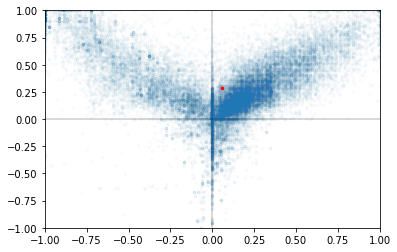

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.axhline(y=0, color='k',linewidth=0.3)
ax.axvline(x=0, color='k',linewidth=0.3)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.scatter(train_cont[:,0]*2-1,train_cont[:,1]*2-1,s=7,alpha=0.02)
ax.scatter(np.mean(train_cont[:,0])*2-1,np.mean(train_cont[:,1])*2-1,s=7,c=(1,0,0))
fig.show()

In [ ]:
## Putting the data into training classes:
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(train_faces, train_cont, test_size=0.20, shuffle= True)

batch_size=64
#### Fit the dataset
train_datagen = ImageDataGenerator(rescale=1./255,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

training_set=train_datagen.flow(x_train,y_train,batch_size=batch_size)


val_datagen = ImageDataGenerator(rescale=1./255,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

val_set=val_datagen.flow(x_valid,y_valid,batch_size=batch_size)

print('completed')

completed


In [ ]:
### model setup
#data size 128
IMG_SIZE = 128
IMG_DIM =1

def model_vgg13_custom( output_classes=2):
    model = tf.keras.models.Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, IMG_DIM)))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Faltten the model
    model.add(Flatten())

    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.50))

    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.50))

    #Sigmoid Activation function
    model.add(Dense(output_classes, activation='sigmoid'))
    opt = Adam(lr=0.0001, decay=1e-6)
    #Mean Squared Error loss function The metric must be different in regression cases.
    keras.backend.set_epsilon(1) #Used for mape
    model.compile(optimizer=opt, loss='MSE', metrics=['mse', 'mape'])
    #print(model.summary())
    return model
model=model_vgg13_custom()
print('completed')

  opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt)

completed


In [ ]:
###making the training ready
chk_path = '/content/drive/MyDrive/Colab/aff_wild/model_vgg_aff_wild_gray.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                               save_best_only=True,
                               verbose=1,
                               mode='min',
                               moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=3,
                            verbose=1,
                            restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=6,
                                verbose=1,
                                min_delta=0.0001)

steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = val_set.n // val_set.batch_size

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callback = [checkpoint, reduce_lr, csv_logger]
print(steps_per_epoch)
print(validation_steps)

print('completed')

436
109
completed


In [ ]:
#tf.device('/device:GPU:0')
with tf.device('/device:GPU:0'):
  device_name = tf.test.gpu_device_name()
  print(device_name)
  #if device_name != '/device:GPU:0':
  #  raise SystemError('GPU device not found')

/device:GPU:0


In [ ]:
with tf.device('/device:GPU:0'):
  epochs=40
  model_hist = model.fit(x=training_set,
                  validation_data=val_set,
                  epochs=epochs,
                  callbacks=callback,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps)
save_path = '/content/drive/MyDrive/Colab/aff_wild/model_vgg_aff_wild_gray_finished.h5'
model.save_weights(save_path)

Epoch 1/40
436/436 [==============================] - 75s 167ms/step - loss: 0.0752 - mse: 0.0752 - mape: 21.6177 - val_loss: 0.0346 - val_mse: 0.0346 - val_mape: 14.3412

Epoch 00001: val_loss improved from inf to 0.03463, saving model to /content/drive/MyDrive/Colab/aff_wild/model_vgg_aff_wild_gray.h5
Epoch 2/40
436/436 [==============================] - 73s 167ms/step - loss: 0.0509 - mse: 0.0509 - mape: 17.6296 - val_loss: 0.0292 - val_mse: 0.0292 - val_mape: 12.5416

Epoch 00002: val_loss improved from 0.03463 to 0.02918, saving model to /content/drive/MyDrive/Colab/aff_wild/model_vgg_aff_wild_gray.h5
Epoch 3/40
436/436 [==============================] - 73s 167ms/step - loss: 0.0436 - mse: 0.0436 - mape: 15.9937 - val_loss: 0.0257 - val_mse: 0.0257 - val_mape: 11.3610

Epoch 00003: val_loss improved from 0.02918 to 0.02572, saving model to /content/drive/MyDrive/Colab/aff_wild/model_vgg_aff_wild_gray.h5
Epoch 4/40
436/436 [==============================] - 73s 166ms/step - loss: 

<class 'list'>


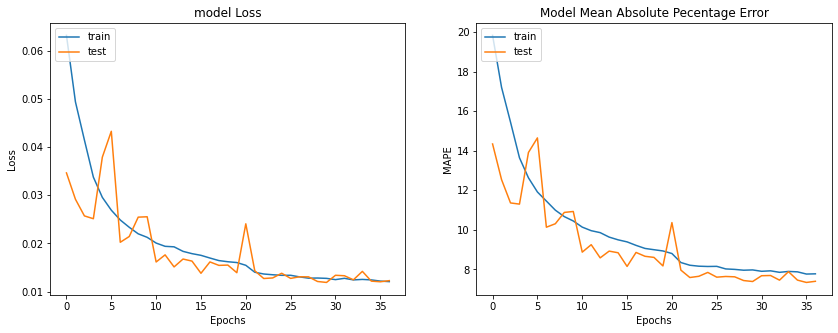

<Figure size 432x288 with 0 Axes>

In [ ]:
###Results for the model
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
print(type(model_hist.history['mse']))
del model_hist.history['mape'][21]
del model_hist.history['val_mape'][21]
plt.plot(model_hist.history['mape'])
plt.plot(model_hist.history['val_mape'])
plt.title('Model Mean Absolute Pecentage Error')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
del model_hist.history['loss'][21]
del model_hist.history['val_loss'][21]
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("/content/drive/MyDrive/Colab/test_accuracy_loss_gray.png")

In [ ]:
def extract_face(frame ):
    # extracting face and body and outputs tensor # add size of output image
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.3, 6)
    # extract ROIS
    if type(faces) is tuple:
        return False
    for (x, y, w, h) in faces:
        # cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        ##simple scalings...
        temp = y - int(h / 3)
        if y - int(h / 3) < 0:
            temp = 0
        roi = gray[y:y + h, x:x +w]
    dim = (128, 128)
    resized = cv.resize(roi, dim, interpolation=cv.INTER_AREA)
    # print(resized.shape)
    #cv.imshow("frame",resized)
    return resized
print("completed")

finished


In [ ]:
##Loading weigths 
PATH_WEIGHTS="/content/drive/MyDrive/Colab/model_vgg_aff_wild_finished.h5"
# Load the previously saved weights
model.load_weights(PATH_WEIGHTS)
print('completed')

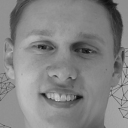

(128, 128)
[[0.0166 0.376 ]]


In [ ]:
import cv2 as cv
from google.colab.patches import cv2_imshow
##Testing

PATH_IMAGE = "/content/drive/MyDrive/Colab/emotion_pics/"
image = "happy.jpg"
frame=cv.imread(PATH_IMAGE+image)
img=extract_face(frame)
cv2_imshow(img)

img=np.resize(img,(img.shape[0],img.shape[1],1))
#print(train_cont)
#print(train_faces)


with tf.device('/device:GPU:0'):
  predicted=model.predict(img[None,...]/255)
  #print(predicted)
  #print(train_cont[6])
  predicted=predicted*2-1
print(predicted)


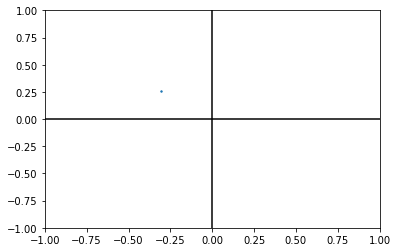

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.scatter(predicted[0][0],predicted[0][1],s=2)
fig.show()